# **Imports**

In [123]:
from google.colab import drive
drive.mount('/content/drive') #montar pasta do google drive dentro dessa pasta do jupyter

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
%config InlineBackend.figure_formats = ['png'] #a imagem que vai aparecer vai estar em png
import numpy as np #computacao numerica em python
import pandas as pd #trabalhar com planilhas
import matplotlib.pyplot as plt #desenhar grafico
from google.colab import files #trabalhar com arquivos
import io #coordenar entradas e saidas do sistemas
import networkx as nx #coracao do programa - desenhar grafos
from collections import Counter #estruturas de dados
from collections import defaultdict 
import matplotlib.patches as mpatch # matplotlib.patches = from matplotlib import patches
import scipy as sp #computacao cientifica (media, mediana, moda, etc)
from functools import reduce
import time #trabalhar com tempo(hora, min, seg)
from math import log
import gspread as gs #trabalhar com arquivos do Google Drive 
from matplotlib.colors import LinearSegmentedColormap #desenho e cores

# **Load Data**

In [139]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('config').sheet1

df_config = pd.DataFrame(worksheet.get_all_values()) #panda . leia o arquivo csv da tabela; mudar o nome do arquivo csv

worksheet = gc.open('model').sheet1

df_model = pd.DataFrame(worksheet.get_all_values()) #panda . leia o arquivo csv da tabela; mudar o nome do arquivo csv

worksheet = gc.open('data').sheet1

df = pd.DataFrame(worksheet.get_all_values()) #panda . leia o arquivo csv da tabela; mudar o nome do arquivo csv


AttributeError: ignored

# **Global Vars**

In [128]:
if df_config.columns.tolist() != ['key', 'value']:
  df_config.columns = df_config.loc[0].values
  df_config = df_config.drop(0)

if df_model.columns.tolist() != ['state', 'color', 'label_state']:
  df_model.columns = df_model.loc[0].values
  df_model = df_model.drop(0)


,state,color,label_state
1,Alert,#FF8C00,Alert
2,Active,#FF0000,Active
3,Quiescence,#00BFFF,Quiescence
4,Unknown,#4169E1,Unknown
5,QHH,#4169E1,QHH


In [129]:
rename_node_ref = df_model.set_index('state').to_dict()['label_state']
color_node_ref = df_model.set_index('label_state').to_dict()['color']

configDict = df_config.set_index('key').to_dict()['value']


FONT_SIZE = int(configDict['FONT_SIZE'])
NODE_SIZE = int(configDict['NODE_SIZE'])
head_length = float(configDict['head_length'])
head_width = float(configDict['head_width'])
EDGE_WIDTH = int(configDict['EDGE_WIDTH'])
Arrow_Style = configDict['Arrow_Style'] 

ROUND_PERCENT = True if configDict['ROUND_PERCENT'] == 'TRUE' else False

USINGTIME = True if configDict['USINGTIME'] == 'TRUE' else False

if USINGTIME:
  if df.columns.tolist() != ['Den', 'Start', 'Stop', 'Behavior']:
    df.columns = df.loc[0].values
    df = df.drop(0)
else:
  if df.columns.tolist() != ['Den', 'Behavior']:
    df.columns = df.loc[0].values
    df = df.drop(0)



def printFiles(fig, plt, name):
    plt.draw()
    fig.savefig(name+'.svg', dpi=100)
    fig.savefig(name+'.pdf', dpi=100)

def rename(name):
    name = name.rstrip() # tirar espacos em branco do lado direito
    name = name.lstrip() # tirar espacos em branco do lado esquerdo
    name = name.capitalize() #colocar primeira letra maiuscula
    
    
    return name


# **Std Graph**

In [130]:
def mountEdges():

  animals = df['Den'].values.tolist() 

  if USINGTIME :
    starts = df['Start'].values.tolist()

    stops = df['Stop'].values.tolist()
  
  states = df['Behavior'].values.tolist()

  states_len = len(states)

  edges =[]

  for i in range(states_len):
          if i > 0 and i < (states_len -1):
            if False :
              if animals[i] == animals[i+1] and stops[i] == starts[i+1] and states[i] != states[i+1]: # condicoes, se o final do evento active foi igual ao inicio desse evento
                edges.append((
                    rename(states[i]),
                    rename(states[i+1])
                ))
            else:
              if animals[i] == animals[i+1] and states[i] != states[i+1]: # condicoes, se o final do evento active foi igual ao inicio desse evento
                edges.append((
                    rename(states[i]),
                    rename(states[i+1])
                ))
  return edges


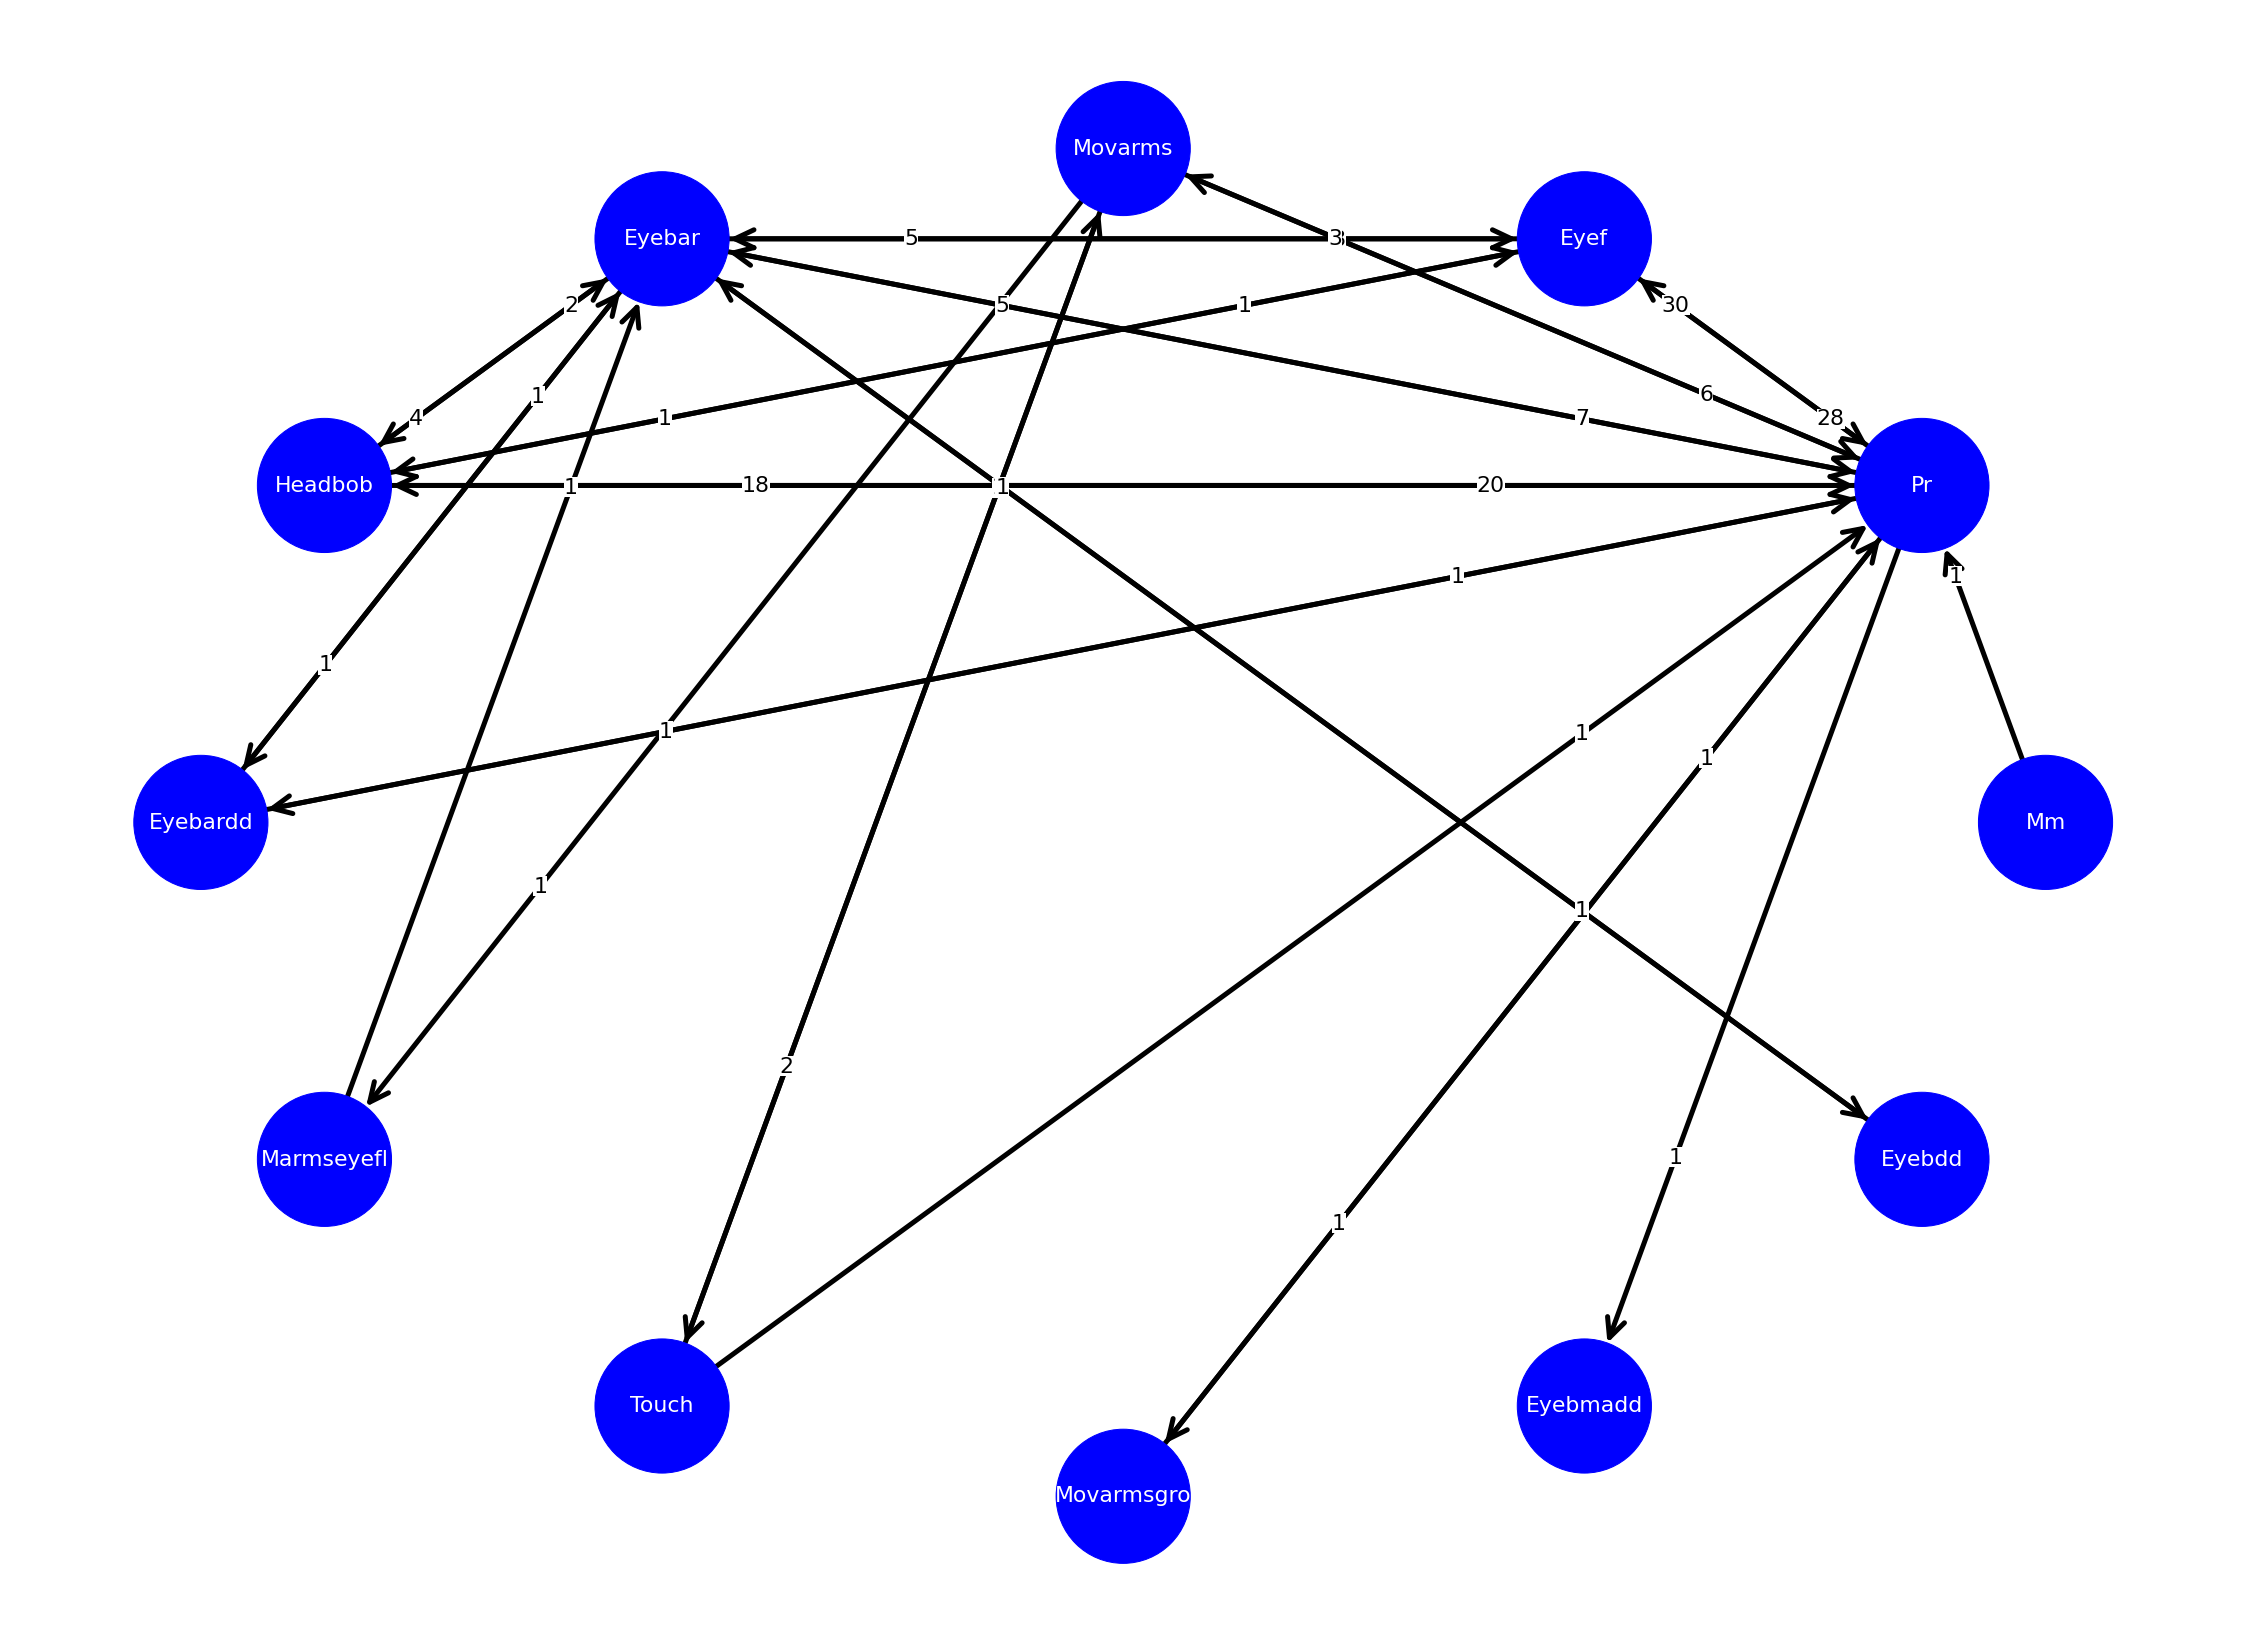

In [131]:


edges = mountEdges()
G = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(edges).items())

pos = nx.layout.circular_layout(G, scale=10) # positions for all nodes

def add_color(colors, node):
    colors.append(color_node_ref.get(node, '#0000FF'))
    return colors

node_sizes = NODE_SIZE
# node_colors = 'blue'
node_colors = reduce(add_color, G.nodes, [])

# print nodes
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    #node_cmap=plt.get_cmap('jet'),
    cmap=plt.get_cmap('jet'),
)

# print the nodes' label
nx.draw_networkx_labels(
    G,
    pos,
    font_size=FONT_SIZE,
    font_color='w',
    font_family='sans-serif'
)

# print edges
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    #node_color=node_colors,
    width=EDGE_WIDTH, arrowstyle= Arrow_Style+", head_length="+str(head_length)+", head_width="+str(head_width),
    arrowsize=10,
    edge_color='k',
    edge_cmap=plt.get_cmap('jet'),
    #cmap=plt.get_cmap('jet')
)

labels = nx.get_edge_attributes(G,'weight')

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=labels,
    font_size=FONT_SIZE,
    label_pos=0.27,
    bbox=dict(facecolor='white', edgecolor='none', pad=0), #remove the big background's label
    rotate=False
)

fig = plt.gcf()
fig.set_size_inches(40, 30)

plt.axis('off')
plt.show()


In [132]:
printFiles(fig, plt, 'graph_std')


<Figure size 432x288 with 0 Axes>

# **Porcent input Graph**

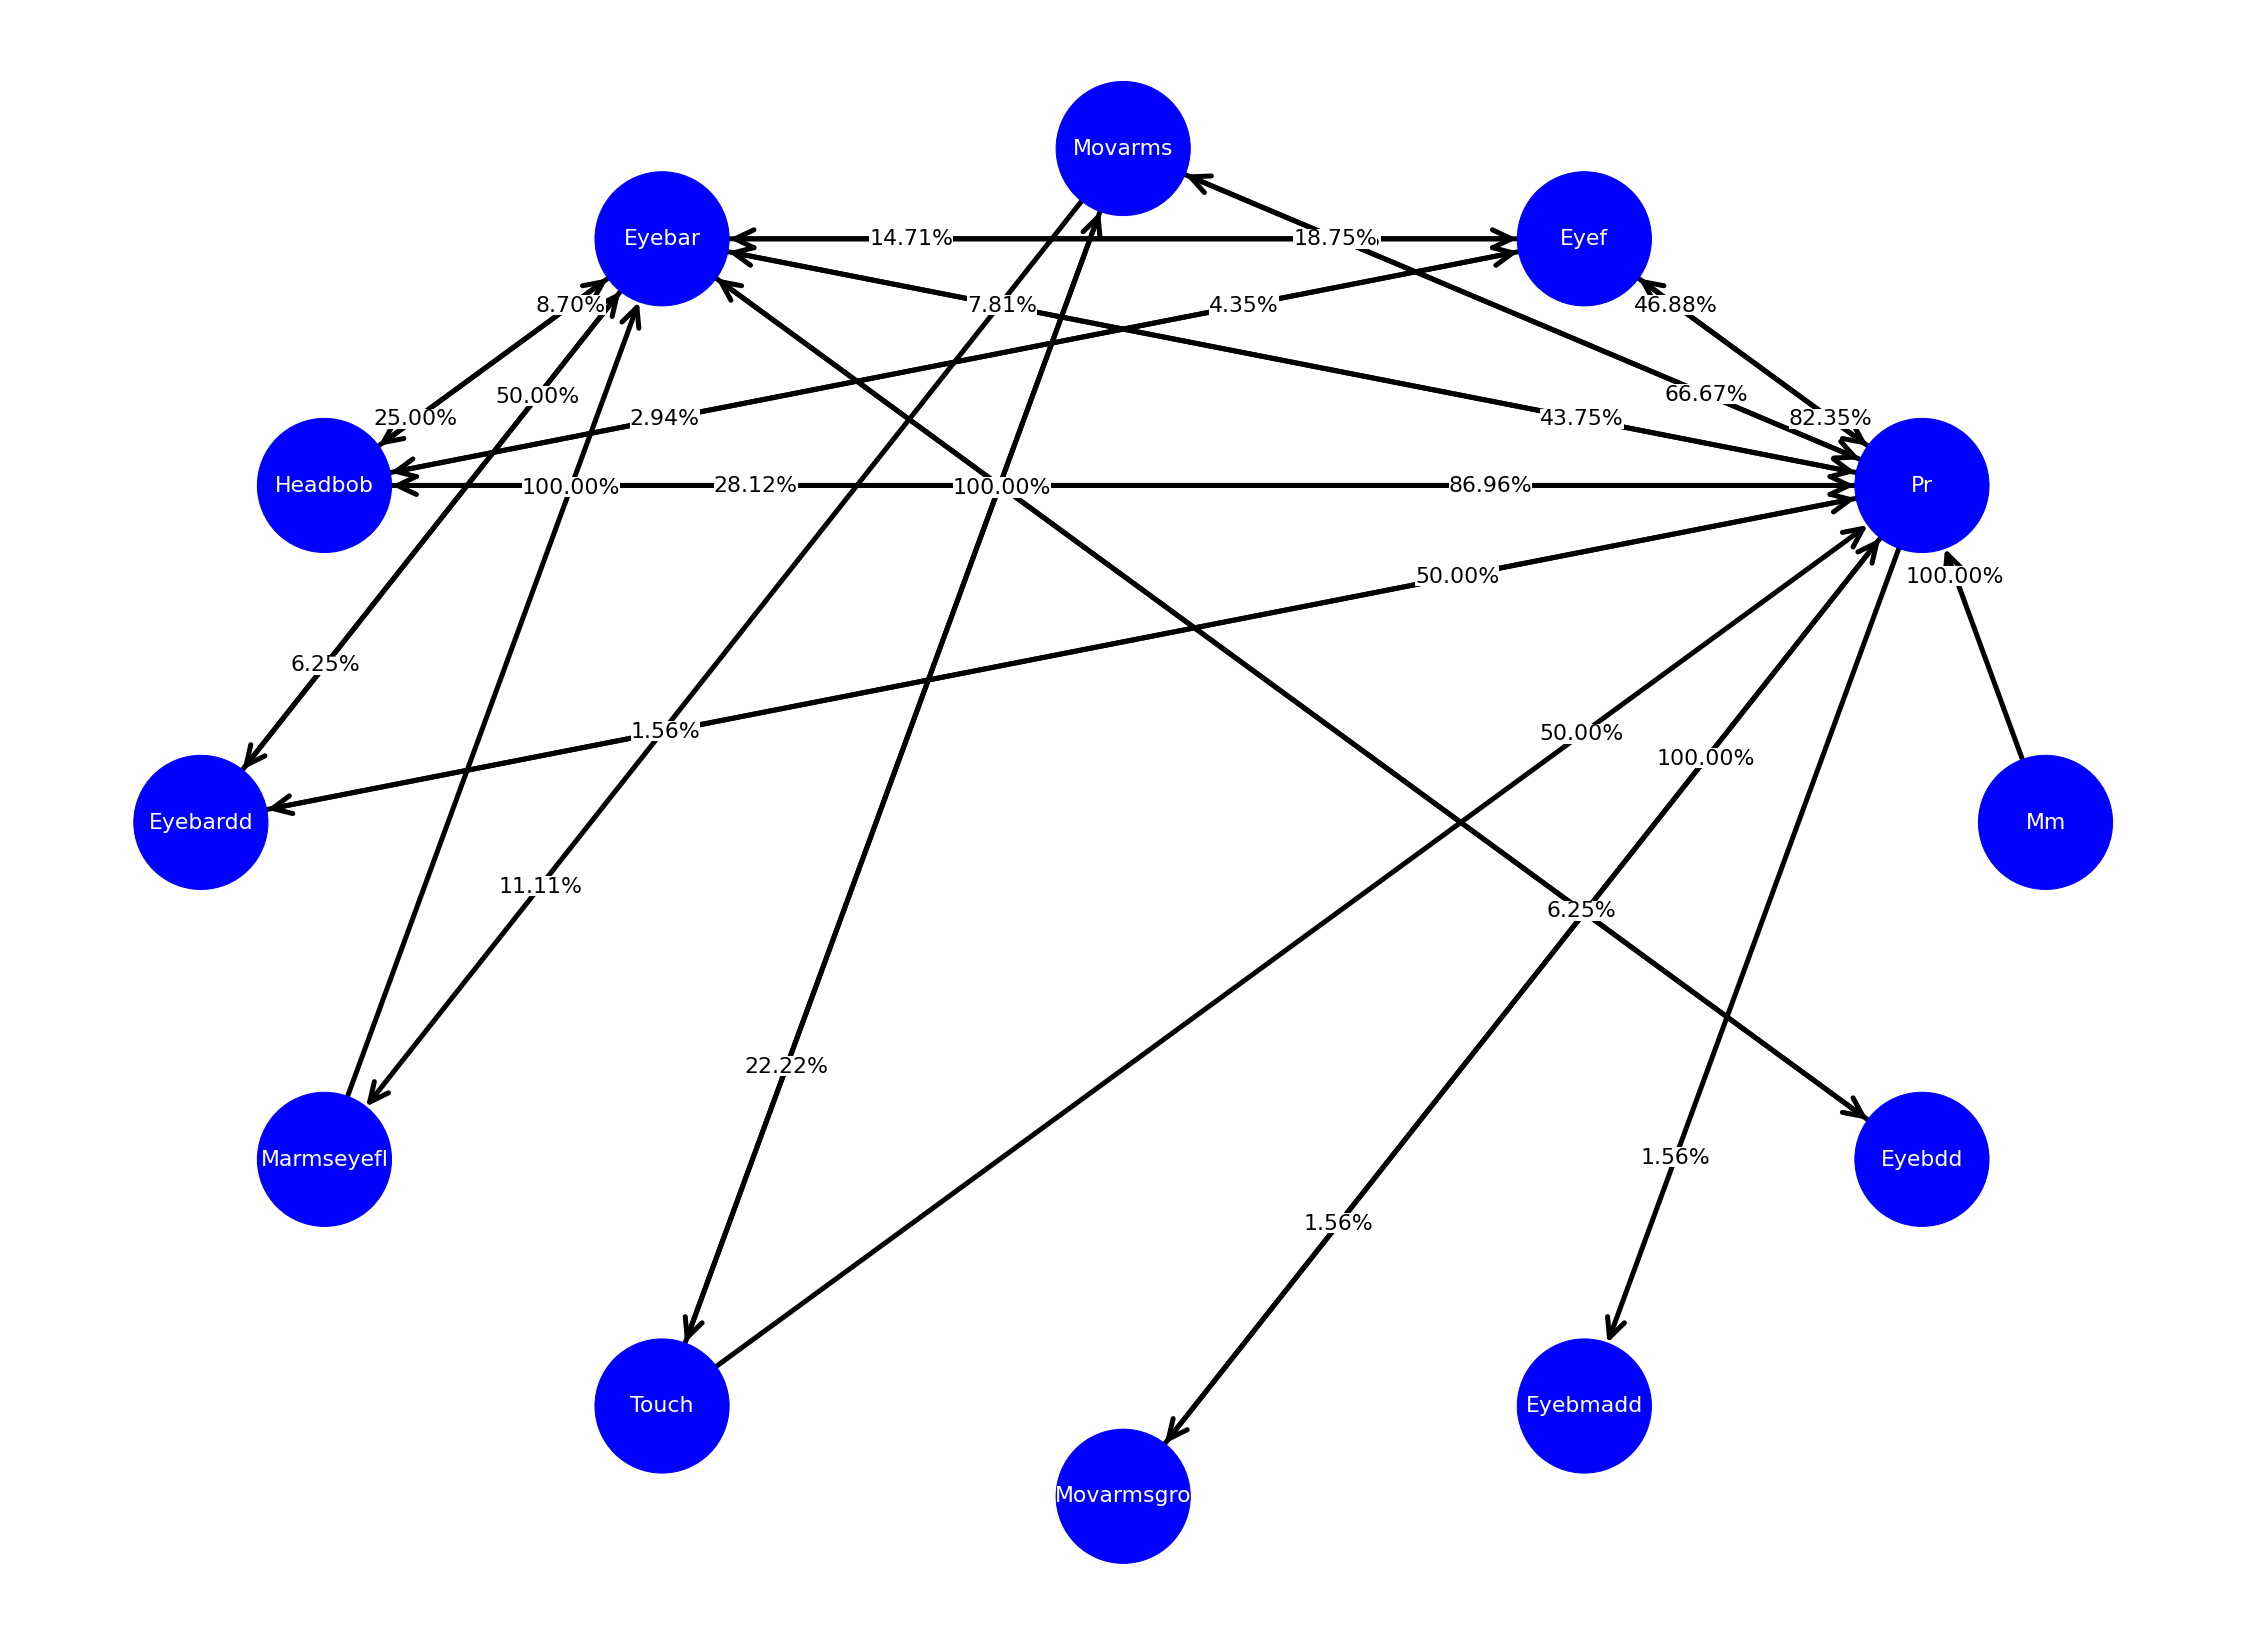

In [133]:
edges = mountEdges()
absolut_weight = [[x,v] for (x, y), v in Counter(edges).items()]
nodes_weight = {}

for aw in absolut_weight:
    if aw[0] in nodes_weight:
        nodes_weight[aw[0]] = nodes_weight[aw[0]] + aw[1]
    else:
        nodes_weight= {**nodes_weight, **{aw[0]:aw[1]}}


if ROUND_PERCENT:
  G = nx.DiGraph((x, y, {'weight': ('{1:.{0}f}%'.format(2, ((v/nodes_weight[x]) * 100)))}) for (x, y), v in Counter(edges).items())
else:
  G = nx.DiGraph((x, y, {'weight':  '{:.0%}'.format((v/nodes_weight[x]))}) for (x, y), v in Counter(edges).items()) 


pos = nx.layout.circular_layout(G, scale=10) # positions for all nodes

def add_color(colors, node):
    colors.append(color_node_ref.get(node, '#0000FF'))
    return colors

node_sizes = NODE_SIZE
# node_colors = 'blue'
node_colors = reduce(add_color, G.nodes, [])

# print nodes
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    #node_cmap=plt.get_cmap('jet'),
    cmap=plt.get_cmap('jet'),
)

# print the nodes' label
nx.draw_networkx_labels(
    G,
    pos,
    font_size=FONT_SIZE,
    font_color='w',
    font_family='sans-serif'
)

# print edges
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    #node_color=node_colors,
    width=EDGE_WIDTH, arrowstyle= Arrow_Style+", head_length="+str(head_length)+", head_width="+str(head_width),
    arrowsize=10,
    edge_color='k',
    edge_cmap=plt.get_cmap('jet'),
    #cmap=plt.get_cmap('jet')
)

labels = nx.get_edge_attributes(G,'weight')

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=labels,
    font_size=FONT_SIZE,
    label_pos=0.27,
    bbox=dict(facecolor='white', edgecolor='none', pad=0), #remove the big background's label
    rotate=False
)

fig = plt.gcf()
fig.set_size_inches(40, 30)

plt.axis('off')
plt.show()

In [134]:
printFiles(fig, plt, 'graph_porcent_input')

<Figure size 432x288 with 0 Axes>

# **Porcent output Graph**

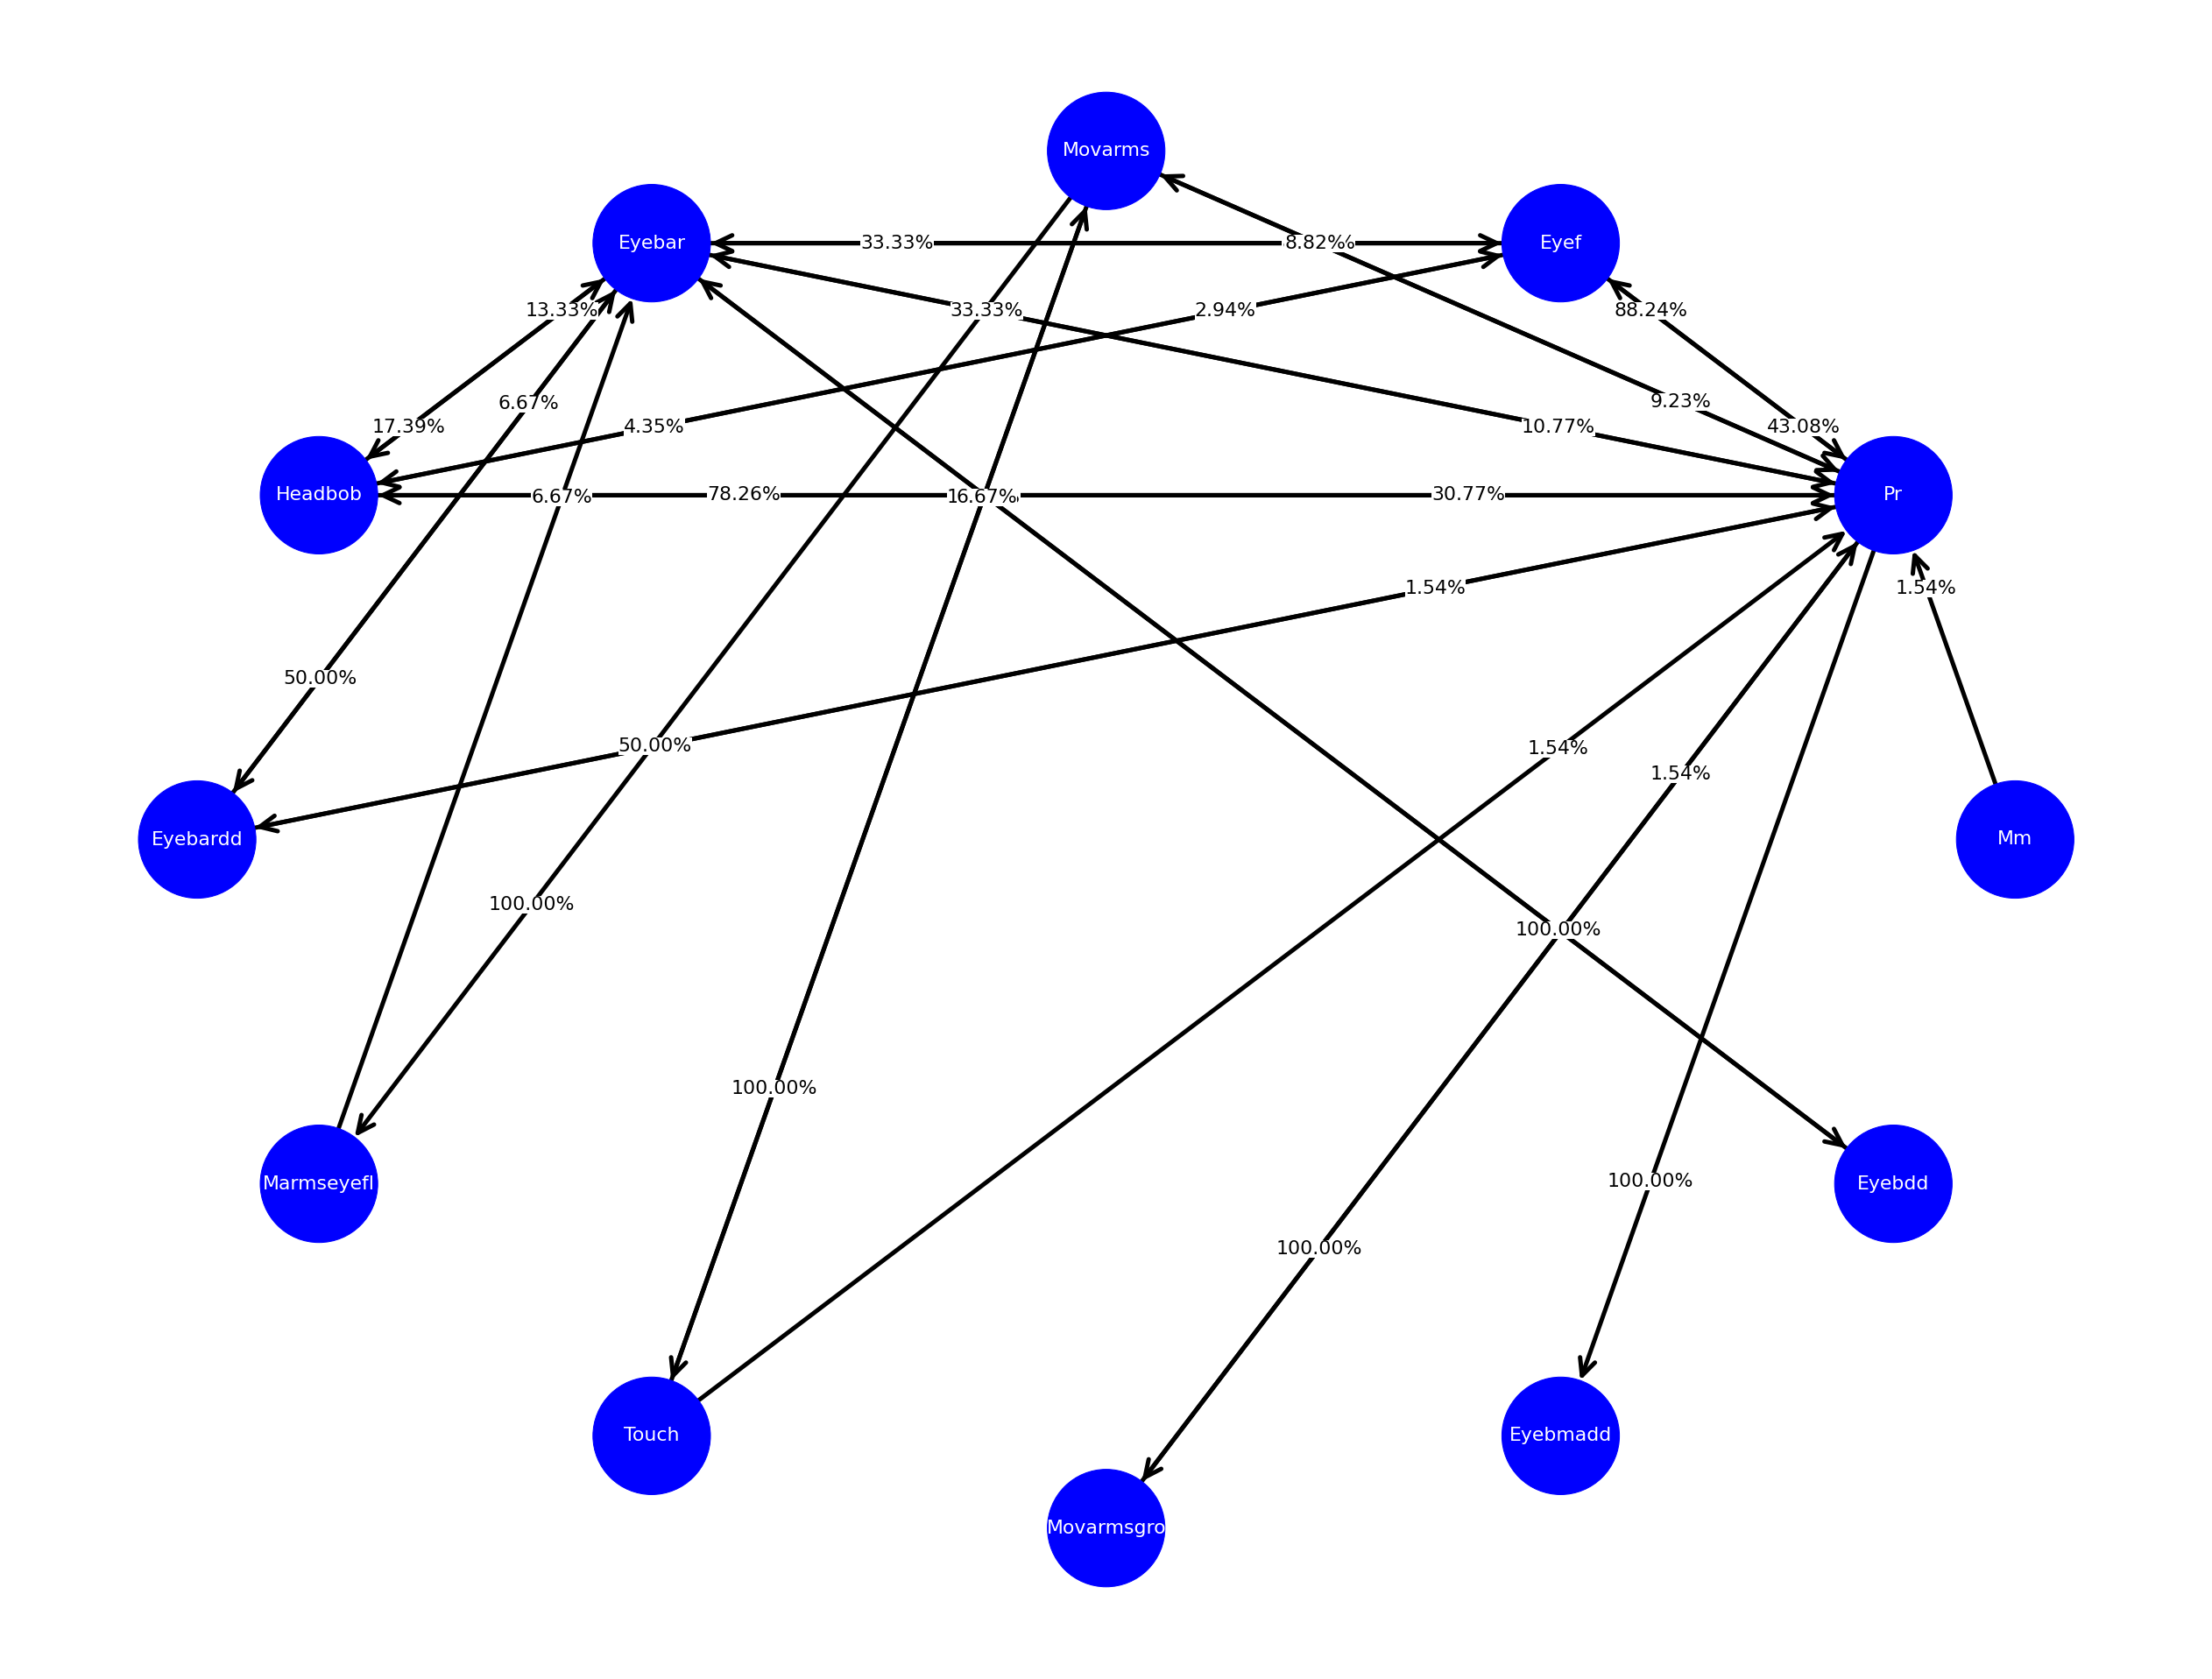

In [135]:
edges = mountEdges()
perc_values = {
                    (xa, ya): va / sum([vb for (xb, yb), vb in Counter(edges).items() if yb == ya])
                    for (xa, ya), va in Counter(edges).items()
                }

if ROUND_PERCENT:
  G = nx.DiGraph((x, y, {'weight': ('{1:.{0}f}%'.format(2, (perc_values[(x, y)] * 100)))}) for (x, y), v in Counter(edges).items())
else:
  G = nx.DiGraph((x, y, {'weight':  '{:.0%}'.format((v/nodes_weight[x]))}) for (x, y), v in Counter(edges).items())                


pos = nx.layout.circular_layout(G, scale=10) # positions for all nodes

def add_color(colors, node):
    colors.append(color_node_ref.get(node, '#0000FF'))
    return colors

node_sizes = NODE_SIZE
# node_colors = 'blue'
node_colors = reduce(add_color, G.nodes, [])

# print nodes
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    #node_cmap=plt.get_cmap('jet'),
    cmap=plt.get_cmap('jet'),
)

# print the nodes' label
nx.draw_networkx_labels(
    G,
    pos,
    font_size=FONT_SIZE,
    font_color='w',
    font_family='sans-serif'
)

# print edges
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    #node_color=node_colors,
    width=EDGE_WIDTH, arrowstyle= Arrow_Style+", head_length="+str(head_length)+", head_width="+str(head_width),
    arrowsize=10,
    edge_color='k',
    edge_cmap=plt.get_cmap('jet'),
    #cmap=plt.get_cmap('jet')
)

labels = nx.get_edge_attributes(G,'weight')

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=labels,
    font_size=FONT_SIZE,
    label_pos=0.27,
    bbox=dict(facecolor='white', edgecolor='none', pad=0), #remove the big background's label
    rotate=False
)

fig = plt.gcf()
fig.set_size_inches(45, 35)

plt.axis('off')
plt.show()

In [136]:
printFiles(fig, plt, 'graph_porcent_output')

<Figure size 432x288 with 0 Axes>

# **Adjacency matrix**

In [137]:
edges = mountEdges()
G = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(edges).items())

print ('start')
print(G)
print ('end')
adj_matrix = nx.adjacency_matrix(G)

plt.imshow(adj_matrix.toarray())

plt.title('Adjacency Matrix')
plt.colorbar()

nodes = G.nodes(data=True)

classes = []

[classes.append(n[0]) for n in nodes]

for i in range(len(classes)):
    for j in range(len(classes)):
        text = plt.text(j, i, adj_matrix[i, j], ha="center", va="center", color="w")

tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fig.set_size_inches(45, 35)
plt.show()

#plt.ylabel('True label')
#plt.xlabel('Predicted label')

start
DiGraph with 12 nodes and 29 edges
end


<ipython-input-137-5c9379c80719>:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


AttributeError: ignored

In [ ]:
printFiles(fig, plt, 'Adjacency_output')